In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Assignment 2 Part 2 - CMPE 258 - Arpitha Gurumurthy

# Overview

In this notebook, learning how to load, explore, visualize, and pre-process a time-series dataset. The output of this notebook is a processed dataset that will be used in following notebooks to build a machine learning model.

### Dataset

City of New York 311 Service Requests
organizationId
(https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-311?utm_campaign=CDR_kwe_aiml_time-series-forecasting_011521&utm_source=external&utm_medium=web&project=cmpe258-hw2-custom&folder=&organizationId

### Objective

The goal is to predict 311 service requests from the City of New York. These non-emergency requests include noise complaints, street light issues, etc.

## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [1]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'CMPE258-HW2-Custom' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-central-1' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [9]:
target = 'y' # The variable you are predicting
# target_description = 'Total Rides' # A description of the target variable
# features = {'day_type': 'Day Type'} # Weekday = W, Saturday = A, Sunday/Holiday = U
ts_col = 'ds' # The name of the column with the date field

# raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'
processed_file = 'new_york_311.csv' # Which file to save the results to

In [10]:
from google.cloud import bigquery as bq
PROJECT = 'cmpe258-hw2-custom' # REPLACE WITH YOUR PROJECT NAME 

sql = """
SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` LIMIT 5
"""

client = bq.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pickup_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,31289655,2015-08-11 10:55:47+00:00,2015-08-11 10:56:26+00:00,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,NYC Street Address,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
1,31290634,2015-08-11 11:37:39+00:00,2015-08-12 08:52:17+00:00,DOF,Adjudication - Hearing by Mail,DOF Parking - Request Copy,Decision and Order,N/A,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
2,31290055,2015-08-11 23:20:46+00:00,2015-08-11 23:20:53+00:00,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,NYC Street Address,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
3,31289701,2015-08-11 09:26:51+00:00,2015-08-11 09:27:11+00:00,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Food Stamp,NYC Street Address,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
4,31289541,2015-08-11 22:10:00+00:00,2015-08-13 04:30:00+00:00,DOT,Department of Transportation,Traffic Signal Condition,Underground,None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None


## Load data

In [11]:
sql2 = """
SELECT
  COUNT(unique_key) as y,
  DATE_TRUNC(DATE(created_date), month) as ds  
FROM `bigquery-public-data.new_york_311.311_service_requests`
GROUP by ds ORDER BY ds asc
"""
df2 = client.query(sql2).to_dataframe()
df2.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [12]:
df2.shape

(135, 2)

In [13]:
# Drop duplicates

df2 = df2.drop_duplicates()

In [14]:
# Sort by date

df2 = df2.sort_index()

## Explore data

In [15]:
# Print the top 5 rows

df2.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [16]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

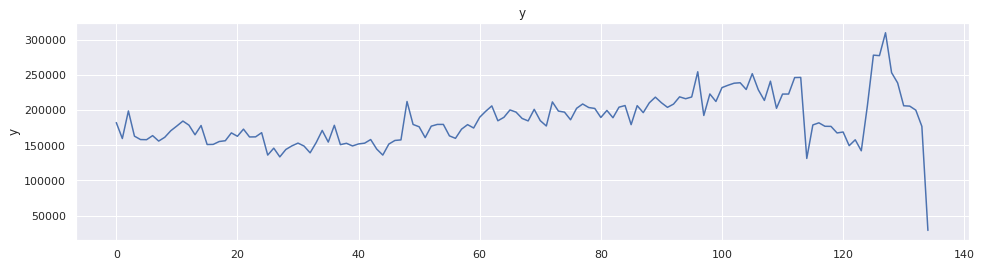

In [17]:
# Explore date over time

sns.lineplot(data=df2, x=df2.index, y=df2['y']).set_title('y')
fig = plt.show()

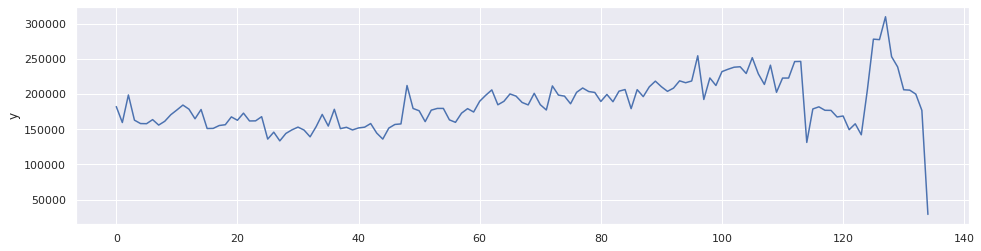

In [18]:
# y - unique_key

sns.lineplot(data=df2, x=df2.index, y=df2['y'])
fig = plt.show()

### TODO 2: Review summary statistics

* How many records are in the dataset?
* What is the average # of riders per day?

In [19]:
df2['y'].describe().apply(lambda x: round(x))

count       135
mean     185675
std       35593
min       29016
25%      159626
50%      179514
75%      205920
max      309696
Name: y, dtype: int64

### TODO 3: Explore seasonality

* Is there much difference between months?
* Can you extract the trend and seasonal pattern from the data?

### Auto-correlation

Next, we will create an auto-correlation plot, to show how correlated a time-series is with itself. Each point on the x-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

Note that the correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

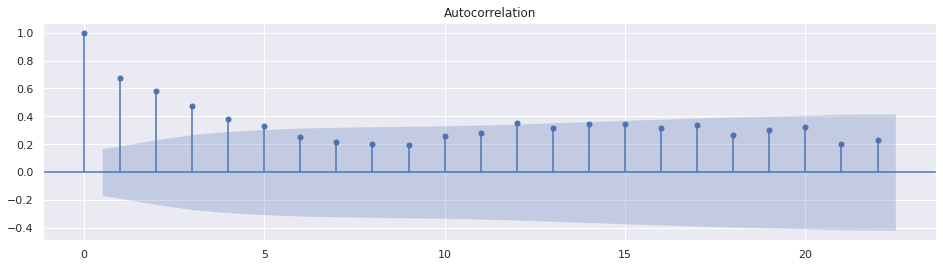

In [29]:
plot_acf(df2['y'])

fig = plt.show()

## Export data

This will generate a CSV file, which you will use in the next labs of this quest.
Inspect the CSV file to see what the data looks like.

In [31]:
df2.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [35]:
df2.to_csv(processed_file)

## Conclusion

In [36]:
df2.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


Learnt how to:
* Create a query that groups data into a time series
* Visualize data
* Decompose time series into trend and seasonal components